In [1]:
#imports
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  
    transforms.Resize((28, 28)),                  
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))    
])

loaders = {
    'train': DataLoader(
        datasets.ImageFolder(
            r'C:\Users\ire0349s\Documents\GitHub\MNIST-Handwritten-Digits\Dataset\train',
            transform=tf
        ),
        batch_size=100,
        shuffle=True,
        num_workers=0 
    ),
    'test': DataLoader(
        datasets.ImageFolder(
            r'C:\Users\ire0349s\Documents\GitHub\MNIST-Handwritten-Digits\Dataset\test',
            transform=tf
        ),
        batch_size=100,
        shuffle=False,
        num_workers=0
    ),
}

In [2]:
#CNN structure
class CNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)  
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        logits = self.fc2(x)
        return logits  

In [3]:
#Creating and optimizing the model
model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)}({100. * batch_idx / len(loaders["train"]): .0f}%)]\t{loss.item():.6f}')

def test():
    
    model.eval()
    
    total_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            logits = model(data)
            loss = loss_fn(logits, target)
            total_loss += loss.item() * data.size(0)  
            pred = logits.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += data.size(0)
    
    avg_loss = total_loss / total
    acc = correct / total
    
    print(f"\nTest set: Average loss: {avg_loss:.4f}, Accuracy {correct}/{total} ({100*acc:.2f}%)\n")

In [4]:
for epoch in range(1, 11):
    train(epoch)
    test()

Train Epoch: 1 [0/60000( 0%)]	2.338014
Train Epoch: 1 [2000/60000( 3%)]	2.161893
Train Epoch: 1 [4000/60000( 7%)]	1.565299
Train Epoch: 1 [6000/60000( 10%)]	0.990590
Train Epoch: 1 [8000/60000( 13%)]	0.938088
Train Epoch: 1 [10000/60000( 17%)]	0.768470
Train Epoch: 1 [12000/60000( 20%)]	0.603414
Train Epoch: 1 [14000/60000( 23%)]	0.694118
Train Epoch: 1 [16000/60000( 27%)]	0.571223
Train Epoch: 1 [18000/60000( 30%)]	0.675944
Train Epoch: 1 [20000/60000( 33%)]	0.493809
Train Epoch: 1 [22000/60000( 37%)]	0.546142
Train Epoch: 1 [24000/60000( 40%)]	0.522941
Train Epoch: 1 [26000/60000( 43%)]	0.482576
Train Epoch: 1 [28000/60000( 47%)]	0.416264
Train Epoch: 1 [30000/60000( 50%)]	0.399335
Train Epoch: 1 [32000/60000( 53%)]	0.404732
Train Epoch: 1 [34000/60000( 57%)]	0.238304
Train Epoch: 1 [36000/60000( 60%)]	0.243881
Train Epoch: 1 [38000/60000( 63%)]	0.392672
Train Epoch: 1 [40000/60000( 67%)]	0.373194
Train Epoch: 1 [42000/60000( 70%)]	0.247048
Train Epoch: 1 [44000/60000( 73%)]	0.569788

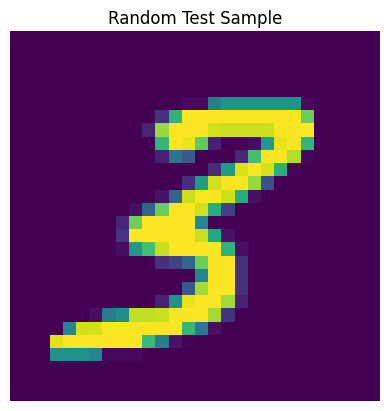

Predicted: 3, Actual: 3


In [5]:
import random
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Switch model to eval mode
model.eval()

# Pick a random sample from the test dataset
idx = random.randrange(len(loaders['test'].dataset))
img, label = loaders['test'].dataset[idx]

# Unnormalize (reverse MNIST normalization)
unnorm = img * 0.3081 + 0.1307

# Plot image
plt.imshow(to_pil_image(unnorm))
plt.axis('off')
plt.title("Random Test Sample")
plt.show()

# Run through model
with torch.no_grad():
    logits = model(img.unsqueeze(0).to(device))
    pred = logits.argmax(1).item()

# Get class names from dataset
class_names = loaders['test'].dataset.classes
print(f"Predicted: {class_names[pred]}, Actual: {class_names[label]}")
